# End to End Medial Diagnostic Use Case 

Steps of the project:
0. Create a virtual environment with python=3.8.13
1. Import and view the data 
2. Check the data for Sanity
3. Perform EDA on data set 
4. Preprocess the data for modelling
5. Fit and Evlaute various Models
6. Optimize the chosen model
7. Interpret the optimized model
8. Pickle and save the model as a pipeline
9. Deploy the model pipeline in streamlit
10. Scale model to cloud using git and streamlit sharing
    

In [1]:
!pip install imbalanced-learn

In [2]:
!pip install xgboost

In [3]:
!pip install shap

In [1]:
# Load all the librarires
# for data manipulation and visualization 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

# preprocessing modules
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE

# modelling modules
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

# modules for model evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import plot_precision_recall_curve

#for model interpretation
import shap

# deployment module
import streamlit as st
import pickle

from sklearn.pipeline import Pipeline
print("All Libraries are imported")

All Libraries are imported


### Import and view the data 

In [2]:
data=pd.read_csv('data.csv')

In [3]:
data.head()

,Unnamed: 0,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0,6,148,72,35,0,33.6,0.627,50,Yes
1,1,1,85,66,29,0,26.6,0.351,31,No
2,2,8,183,64,0,0,23.3,0.672,32,Yes
3,3,1,89,66,23,94,28.1,0.167,21,No
4,4,0,137,40,35,168,43.1,2.288,33,Yes


In [4]:
data.shape

(768, 10)

###  Check the data for Sanity

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                768 non-null    int64  
 1   Pregnancies               768 non-null    int64  
 2   Glucose                   768 non-null    int64  
 3   BloodPressure             768 non-null    int64  
 4   SkinThickness             768 non-null    int64  
 5   Insulin                   768 non-null    int64  
 6   BMI                       768 non-null    float64
 7   DiabetesPedigreeFunction  768 non-null    float64
 8   Age                       768 non-null    int64  
 9   Outcome                   768 non-null    object 
dtypes: float64(2), int64(7), object(1)
memory usage: 60.1+ KB


In [6]:
data.isnull().sum()

Unnamed: 0                  0
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [7]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,768.0,383.500000,221.846794,0.000,191.75000,383.5000,575.25000,767.00
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00


In [8]:
# check for any other non real characters
data[~data.applymap(np.isreal).any(1)]

,Unnamed: 0,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome


**Observations**
1. Data set has 768 rows and 10 columns( 1 redundant)
2. Dataset has no direct nulls but has nulls imputed as 0
3. Dataset has only 1 categorical variable the Outcome


In [9]:
data.columns

Index(['Unnamed: 0', 'Pregnancies', 'Glucose', 'BloodPressure',
       'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age',
       'Outcome'],
      dtype='object')

In [10]:
# drop the redundant column
data=data.drop('Unnamed: 0', axis=1)

In [11]:
# treat the nulls
zerofiller=lambda x: x.replace(0, x.median())
cols=data.columns[1:6]
data[cols]=data[cols].apply(zerofiller, axis=0)

In [12]:
#encode categoricals
df=data.copy()
d={'Yes':1, 'No':0}
df['Outcome']=df['Outcome'].map(d)

In [13]:
df.head(2)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,30.5,33.6,0.627,50,1
1,1,85,66,29,30.5,26.6,0.351,31,0


### Perform EDA on data set 
1. UNIVARIATES- NUMERICALS
2. UNIVARIATES-CATEGORICALS
3. BIVARIATES-NUMERICAL vs CATEGORICAL
4. BIVARIATES- NUMERICALS VS NUMERICLAS
5. MULTIVARIATE CHARTS 
6. Correlations and Heatmaps 

##### 1. UNIVARIATES

In [14]:
def histograms(data):
    print('Univariate Histogram')
    data.hist()
    plt.tight_layout()
    plt.show()

Univariate Histogram


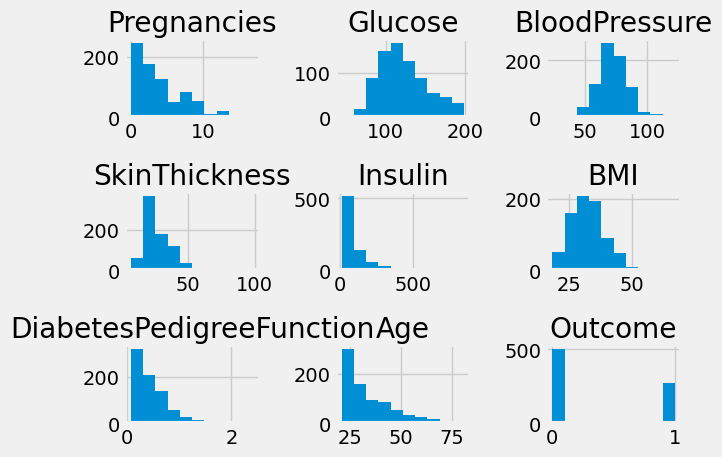

In [15]:
histograms(df)

In [16]:
def barchart(data, feature):
    print("Barchart of Categoricals")
    ax=sns.countplot(data=data, x=feature, color='green')
    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax.annotate("{:.2g}%".format(100.*y/len(data)), (x.mean(),y), ha='center' , va='bottom')                                  
    plt.show()

Barchart of Categoricals


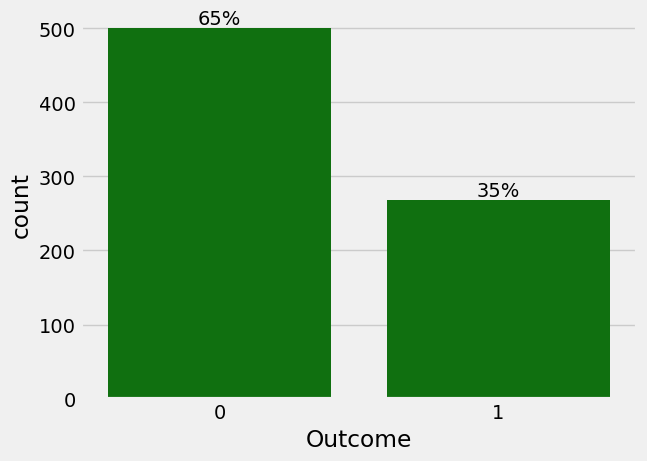

In [17]:
barchart(data=df, feature='Outcome')

**Observations**
Outcome variable is highly imbalanced. We need to solve for data imbalance 

In [18]:
def boxpolot_histplot(data, feature, figsize=(12,7), bins=None):
    print("Univariates of ", feature)
    fig, (ax_box, ax_hist)=plt.subplots(
    nrows=2,
    sharex=True,
    gridspec_kw={'height_ratios':(0.25,0.75)},
    figsize=figsize)
    
    sns.boxplot(data=data,x=feature, showmeans=True, ax=ax_box, color='violet')
    
    sns.histplot(data=data, x=feature, bins=bins, ax=ax_hist, pallete='winter') if bins else\
         sns.histplot(data=data,x=feature, ax=ax_hist)
    plt.axvline(data[feature].mean(),linestyle='--', color='green')
    plt.axvline(data[feature].median(), linestyle='-', color='black')
    plt.show()

Univariates of  Pregnancies


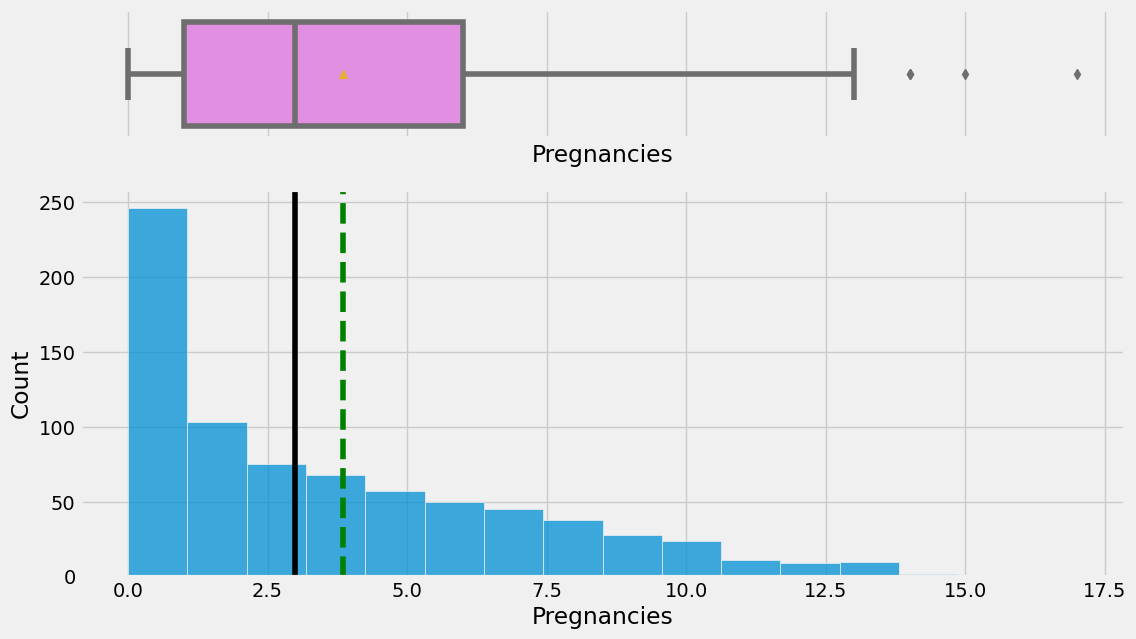

Univariates of  Glucose


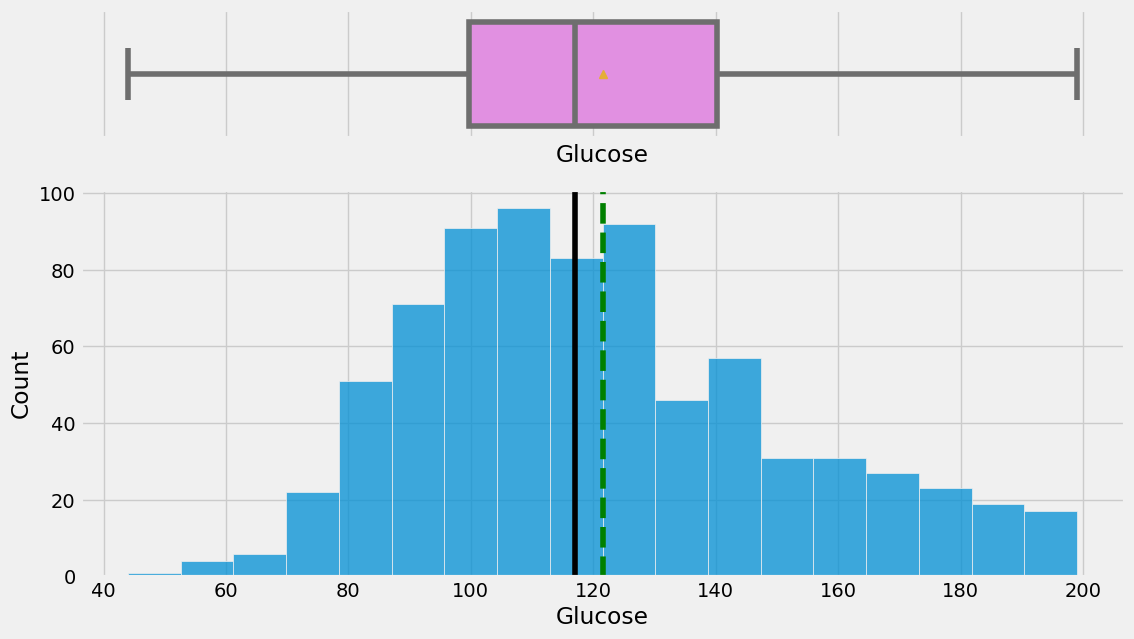

Univariates of  BloodPressure


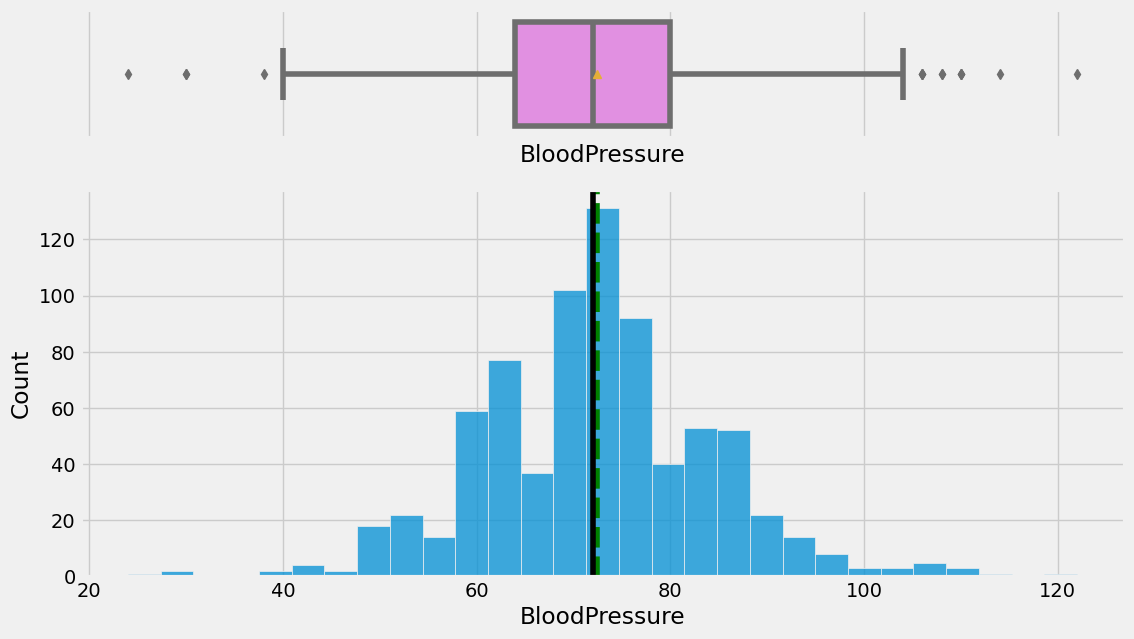

Univariates of  SkinThickness


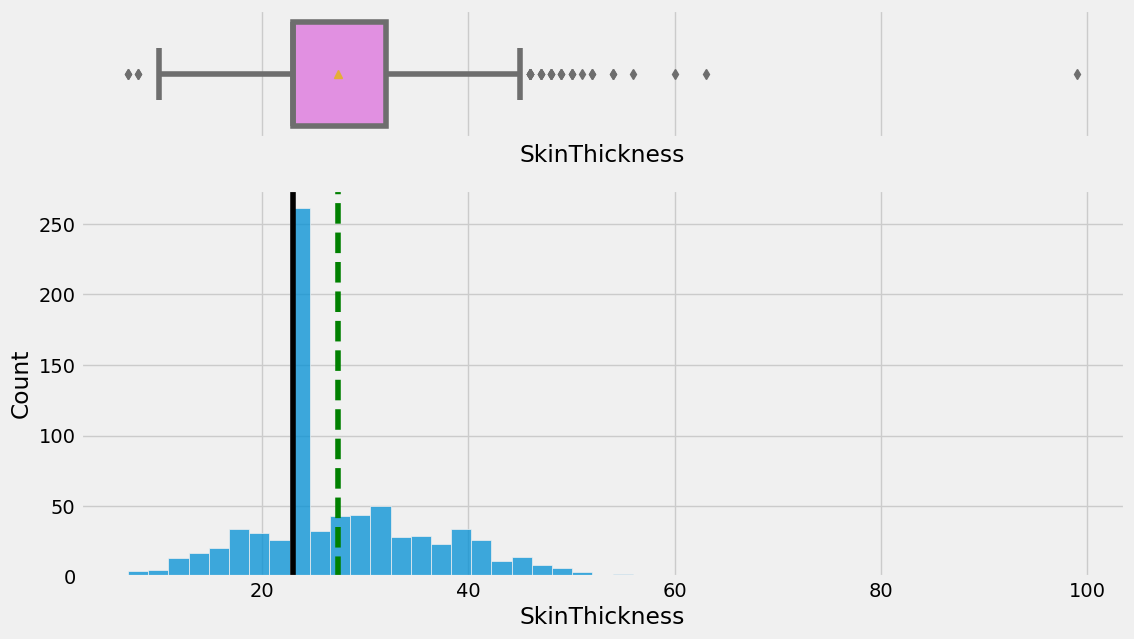

Univariates of  Insulin


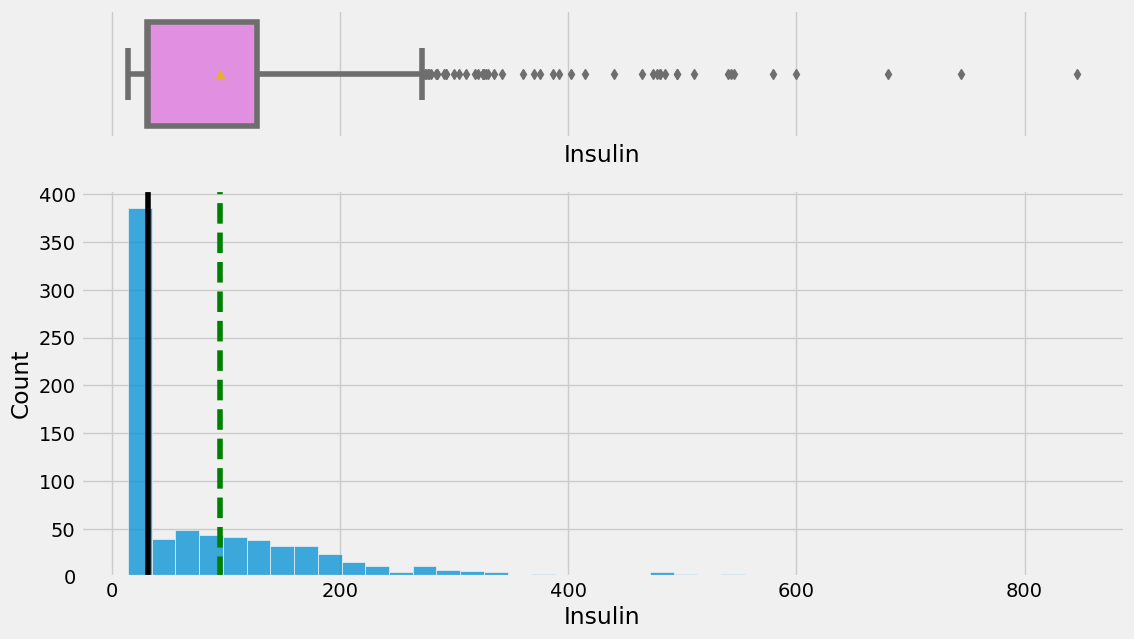

Univariates of  BMI


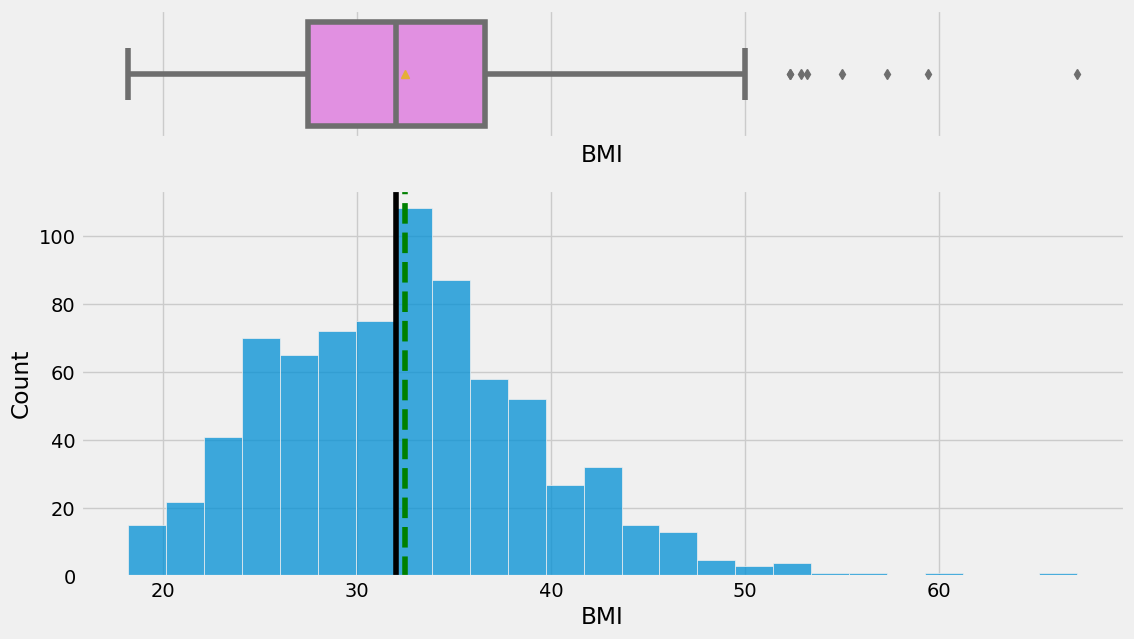

Univariates of  DiabetesPedigreeFunction


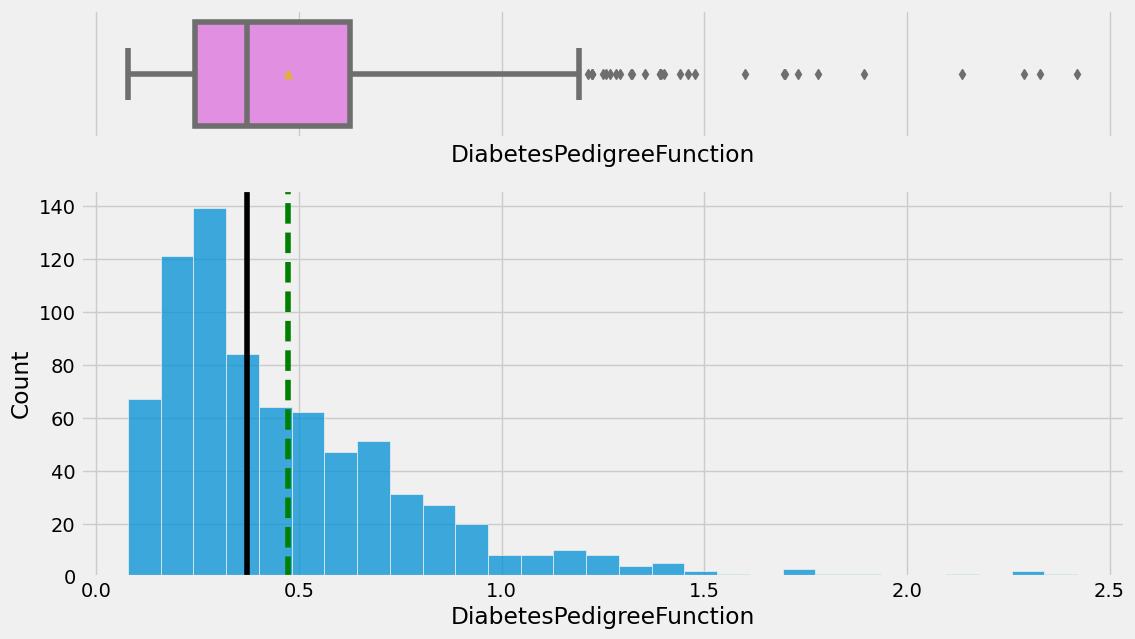

Univariates of  Age


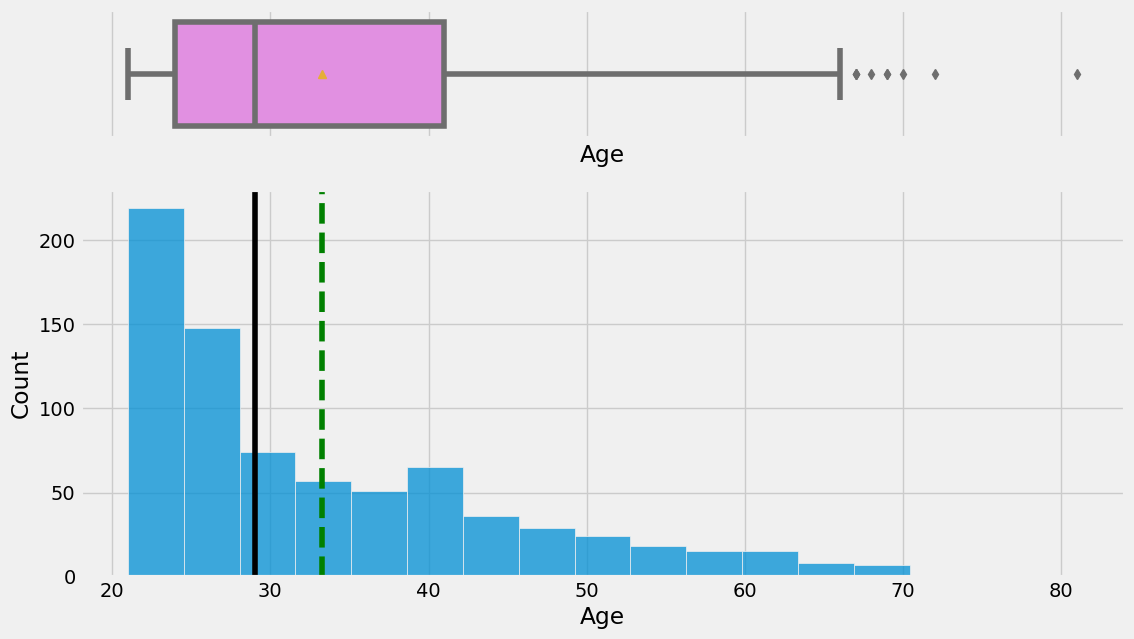

Univariates of  Outcome


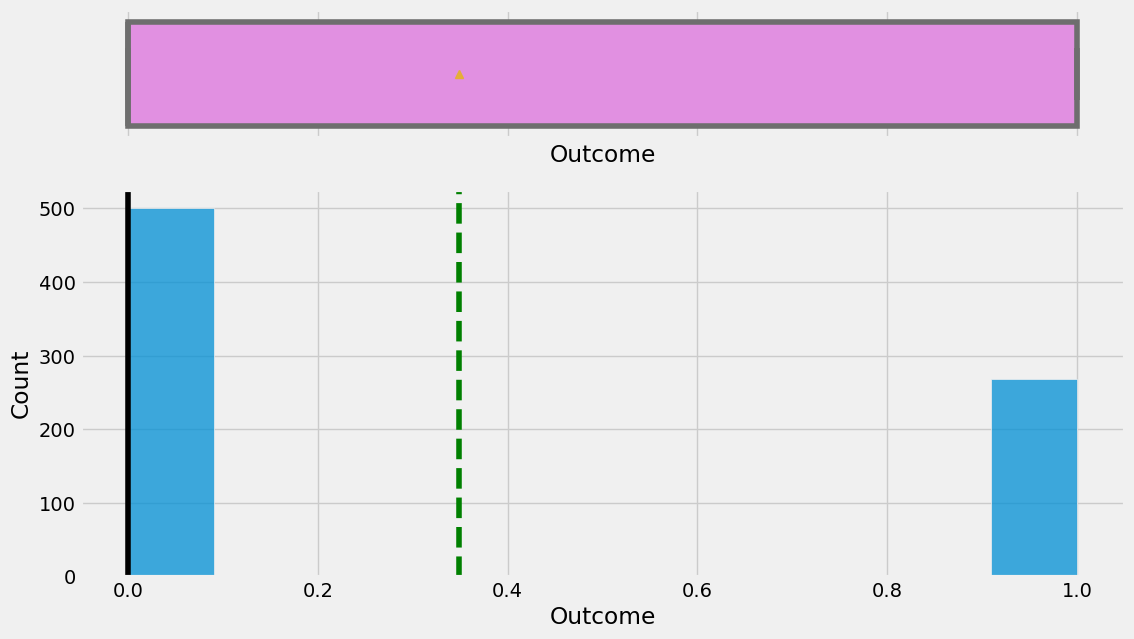

In [19]:
for col in df.select_dtypes(exclude='O').columns:
    boxpolot_histplot(data=df, feature=col)

**Observations**
1. Pregnancies has some suspect outliers which have to be looked upon
2. Skin thickness also has some suspect outliers which need to be taken care of 
3. Insulin is highly right skewed aand may need to be engineered
4. Diabetes pedigree function is also highly right skewed and needs to be engineered.
5. Outcome is highly imbalanced and may need balancing.

##### BIVARIATES-NUMERICAL vs CATEGORICAL

In [20]:
def catnums(data, feature1, feature2):
    print("Bivariate Barchart between {0} and {1}".format(feature1, feature2))
    data.groupby(feature1)[feature2].mean().plot(kind='bar',color='orange')
    plt.show()

Bivariate Barchart between Outcome and Pregnancies


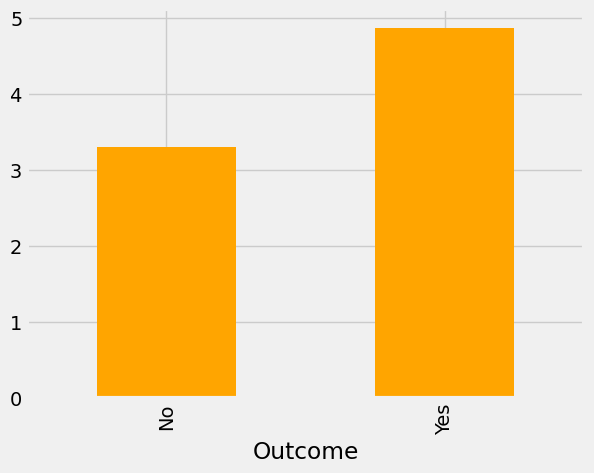

Bivariate Barchart between Outcome and Glucose


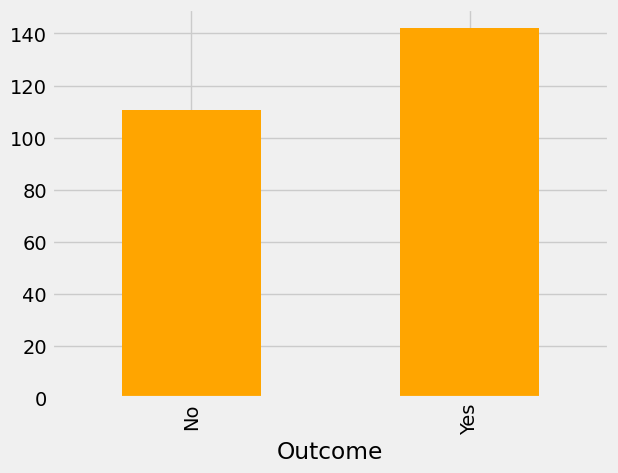

Bivariate Barchart between Outcome and BloodPressure


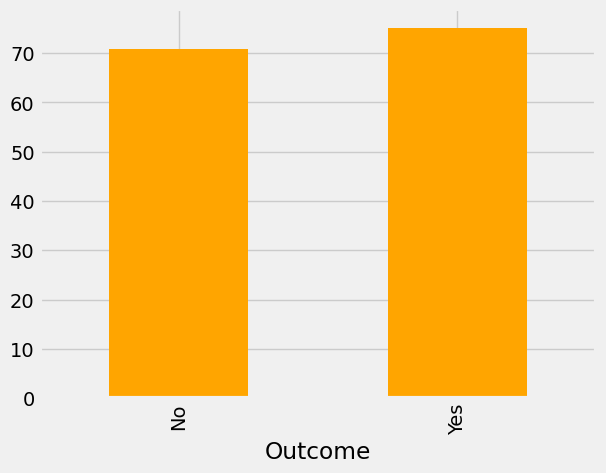

Bivariate Barchart between Outcome and SkinThickness


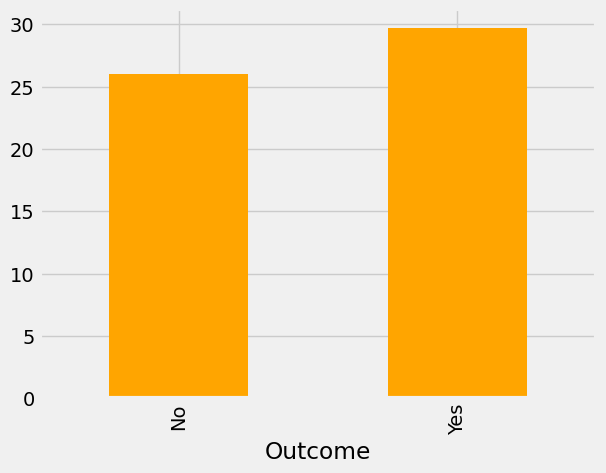

Bivariate Barchart between Outcome and Insulin


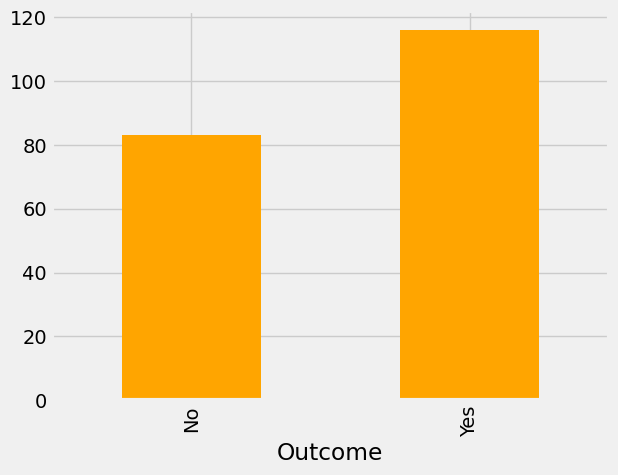

Bivariate Barchart between Outcome and BMI


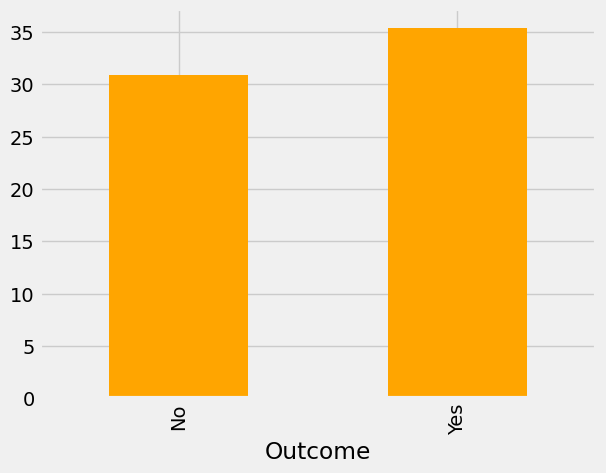

Bivariate Barchart between Outcome and DiabetesPedigreeFunction


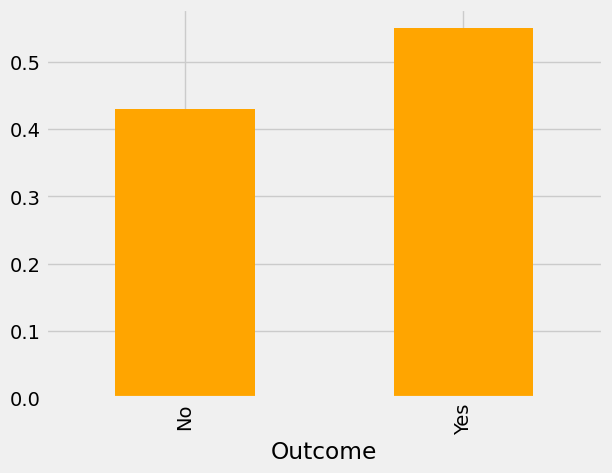

Bivariate Barchart between Outcome and Age


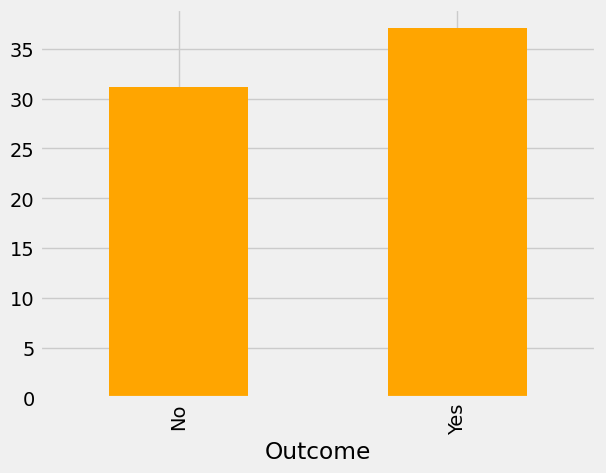

In [21]:
for col in data.select_dtypes(exclude='O').columns:
    catnums(data=data, feature1='Outcome', feature2=col)

**Observations**
Woman with higher pregnancies, higher diabetes predigree functions and Insulin use are more likely to be diabetic

##### BIVARIATES-NUMERICAL vs NUMERICAL

In [22]:
def lineplot_scatterplot(data, feature1, feature2):
    print("Bivariates between {0} and {1}".format(feature1, feature2))
    plt.figure(figsize=(16,7))
    plt.subplot(1,2,1)
    sns.lineplot(data=data, x=feature1, y=feature2, color='green')
    plt.subplot(1,2,2)
    sns.scatterplot(data=data, x=feature1, y=feature2, color='blue')
    plt.show()

Bivariates between Pregnancies and Pregnancies


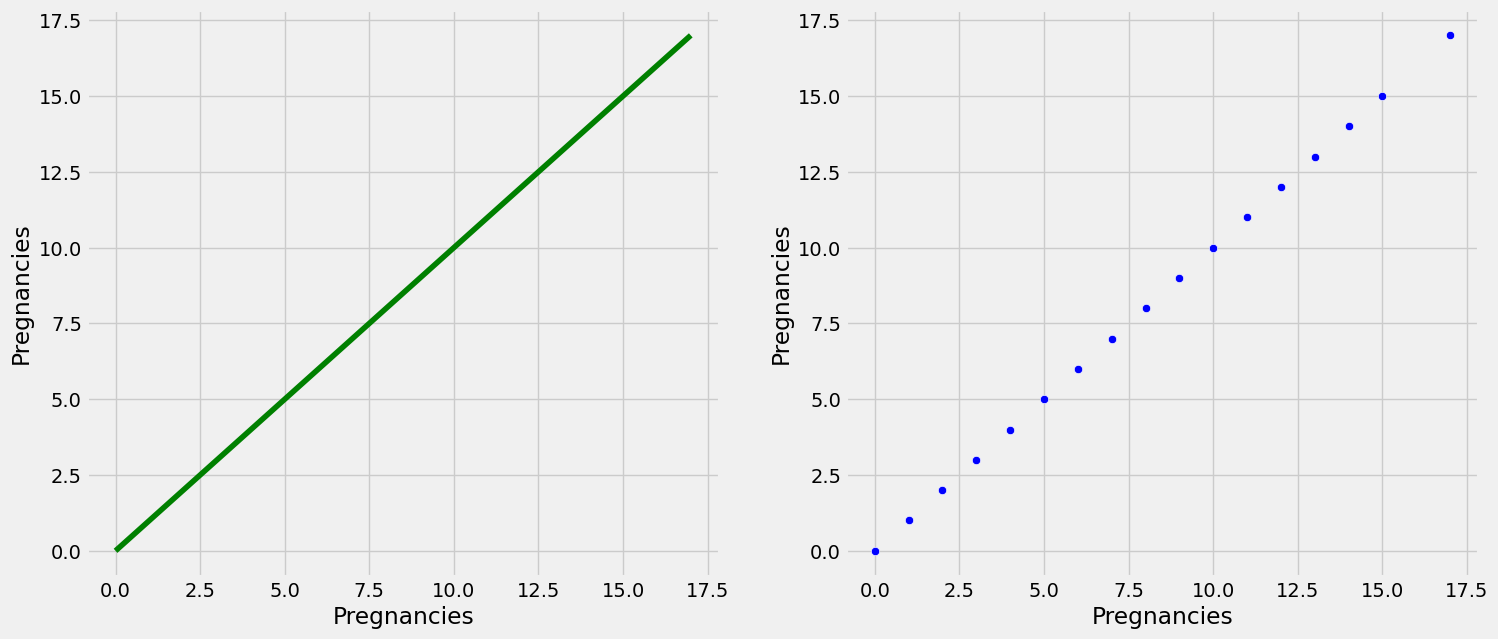

Bivariates between Pregnancies and Glucose


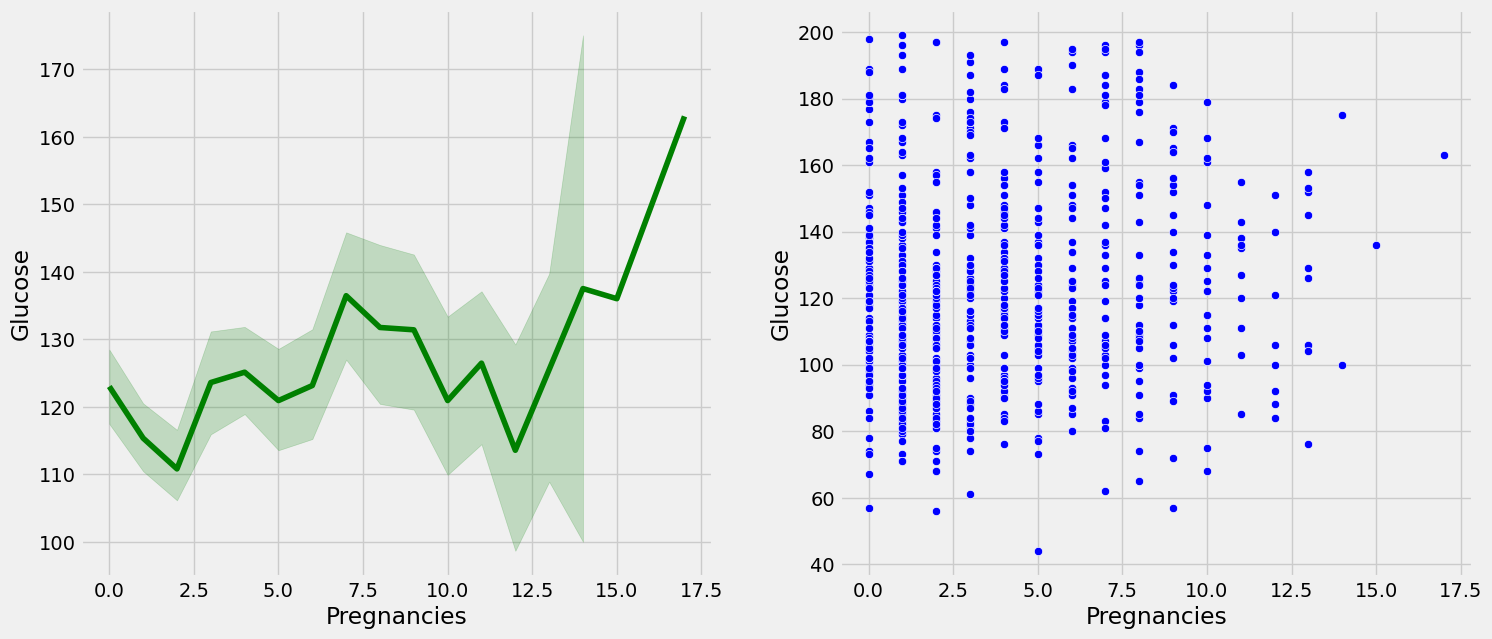

Bivariates between Pregnancies and BloodPressure


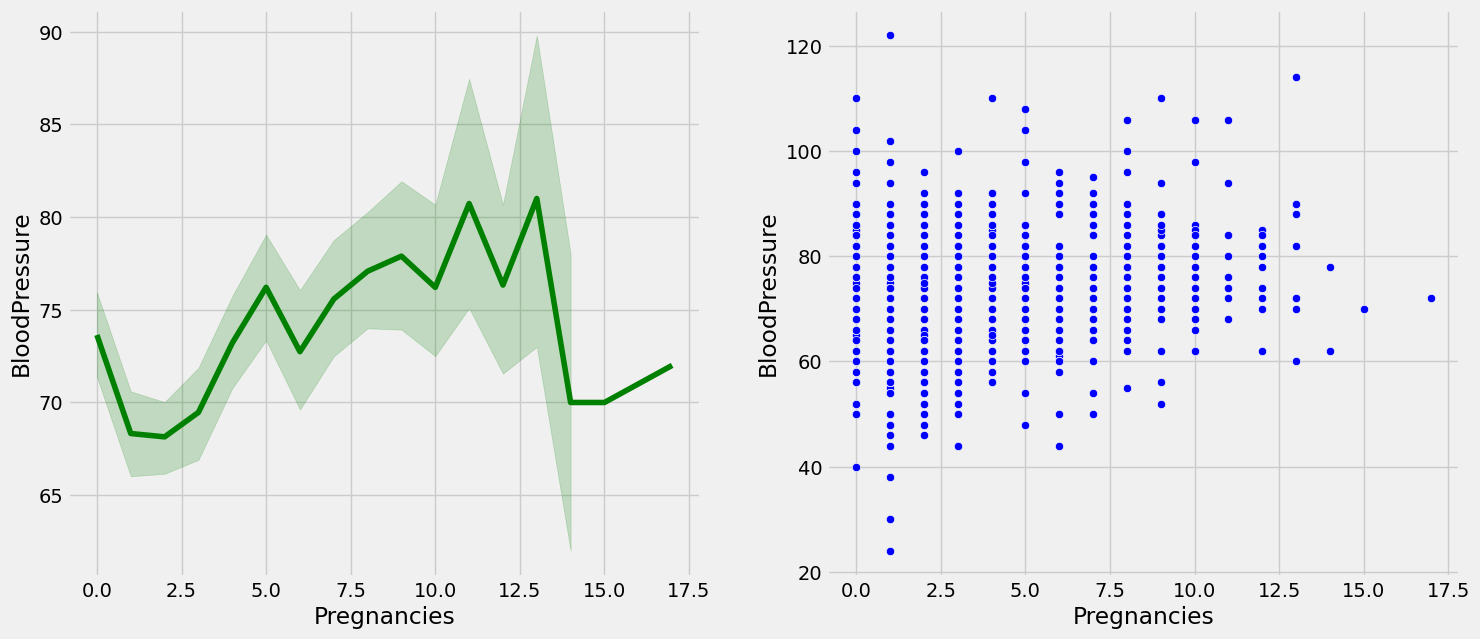

Bivariates between Pregnancies and SkinThickness


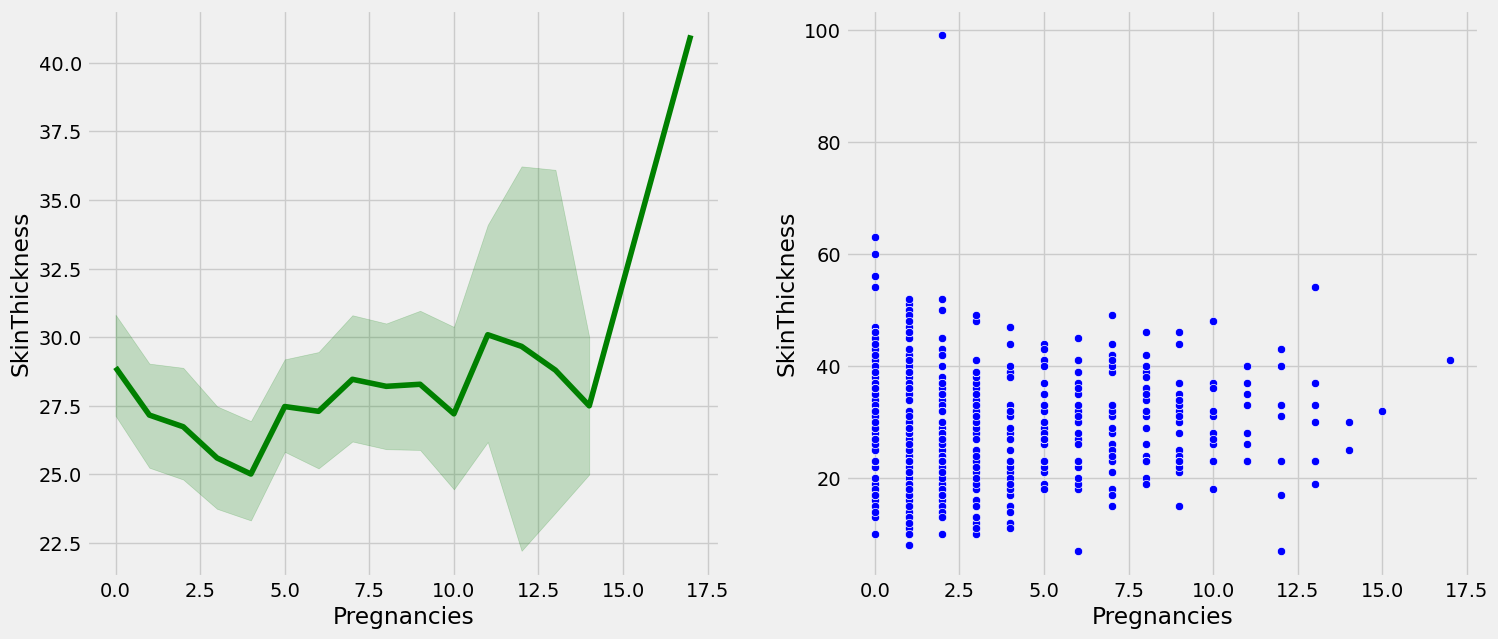

Bivariates between Pregnancies and Insulin


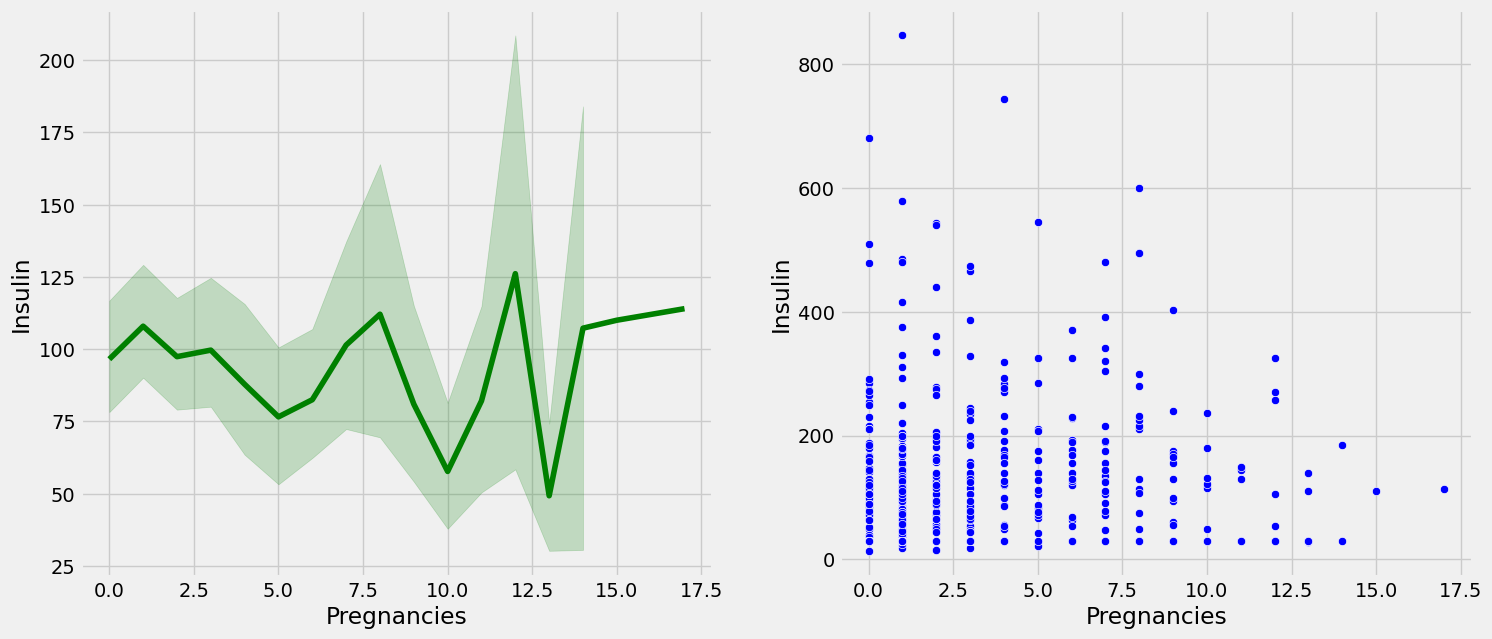

Bivariates between Pregnancies and BMI


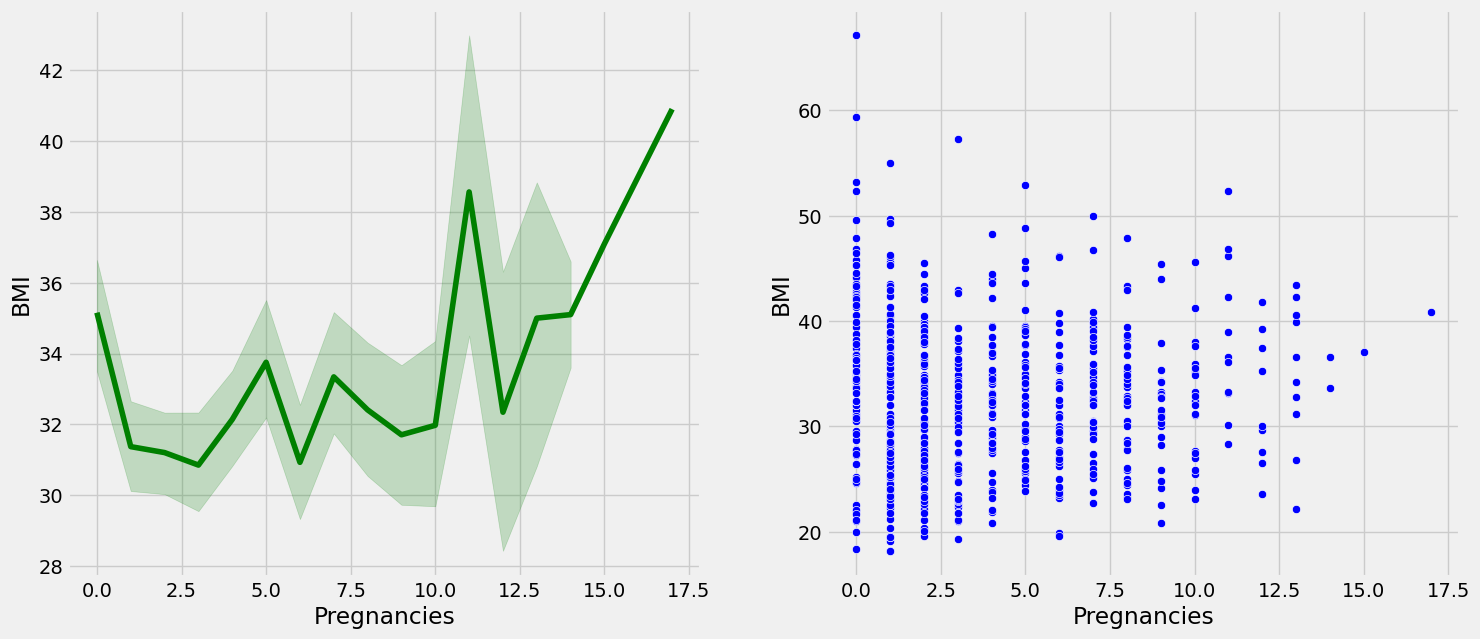

Bivariates between Pregnancies and DiabetesPedigreeFunction


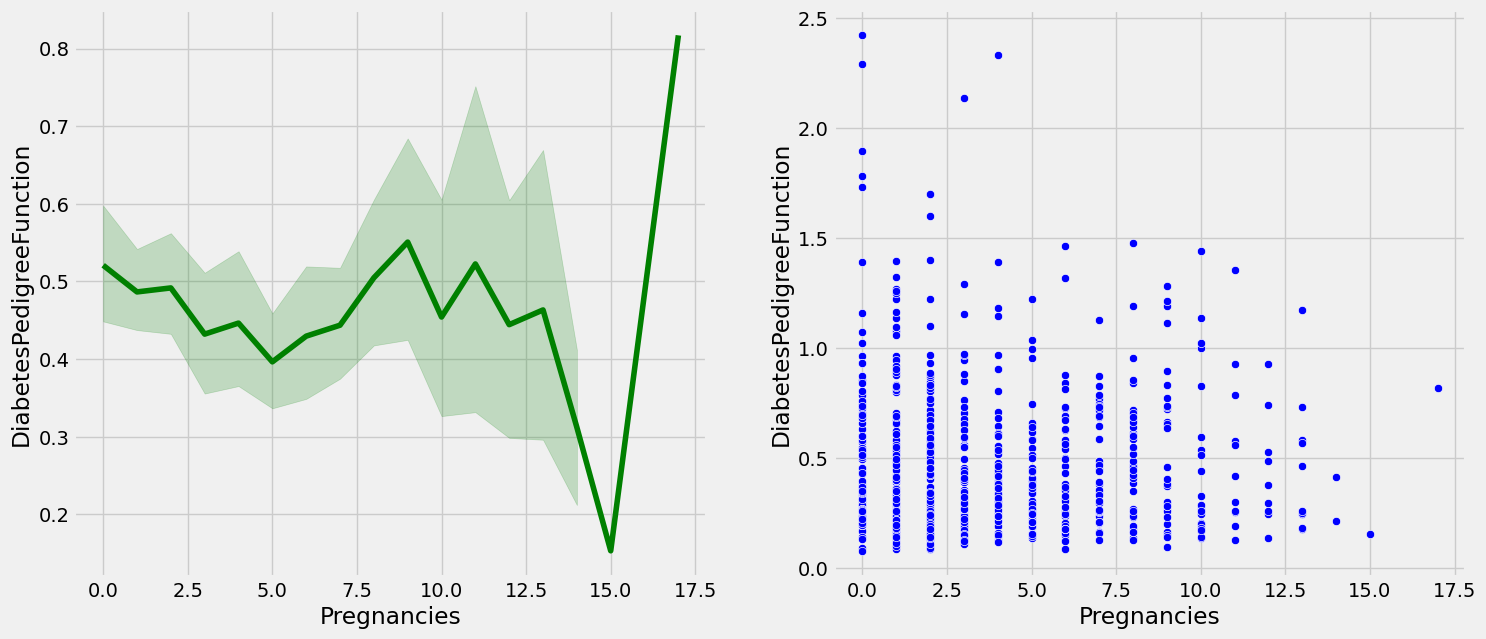

Bivariates between Pregnancies and Age


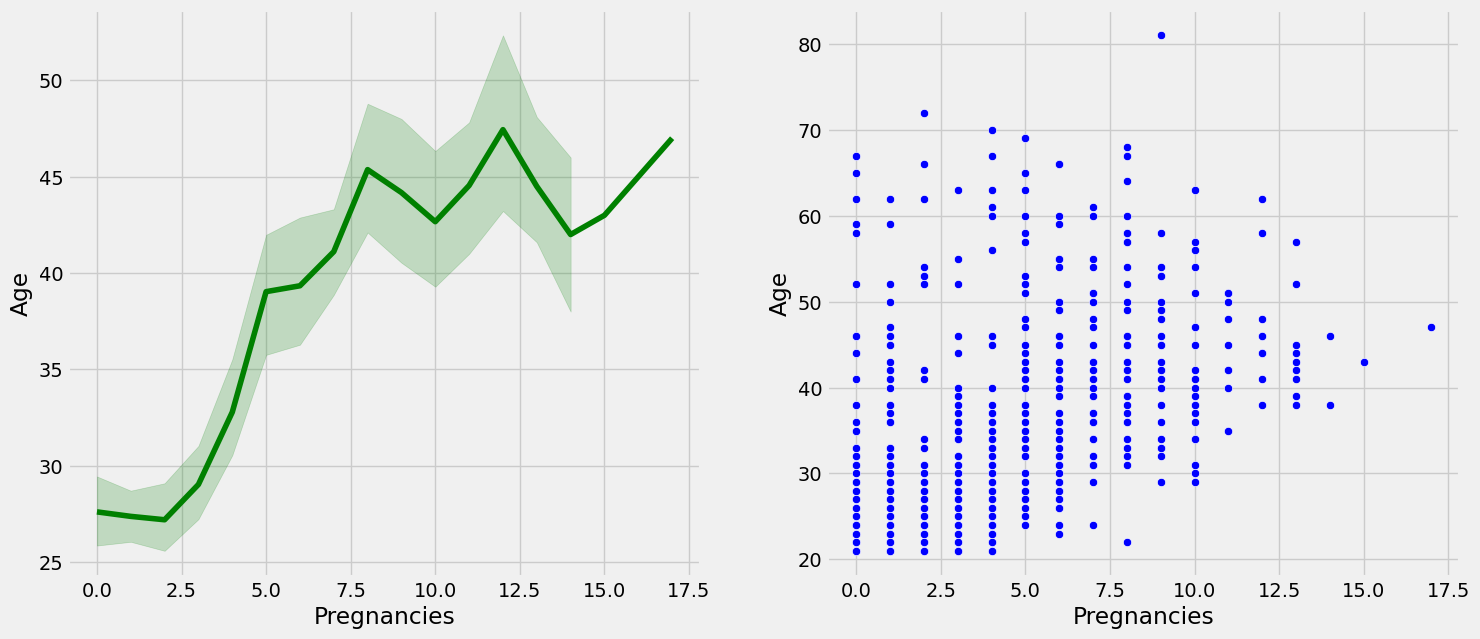

In [23]:
for col in data.select_dtypes(exclude='O').columns:
    lineplot_scatterplot(data=data, feature1='Pregnancies', feature2=col)

##### MULTIVARIATE CHARTS

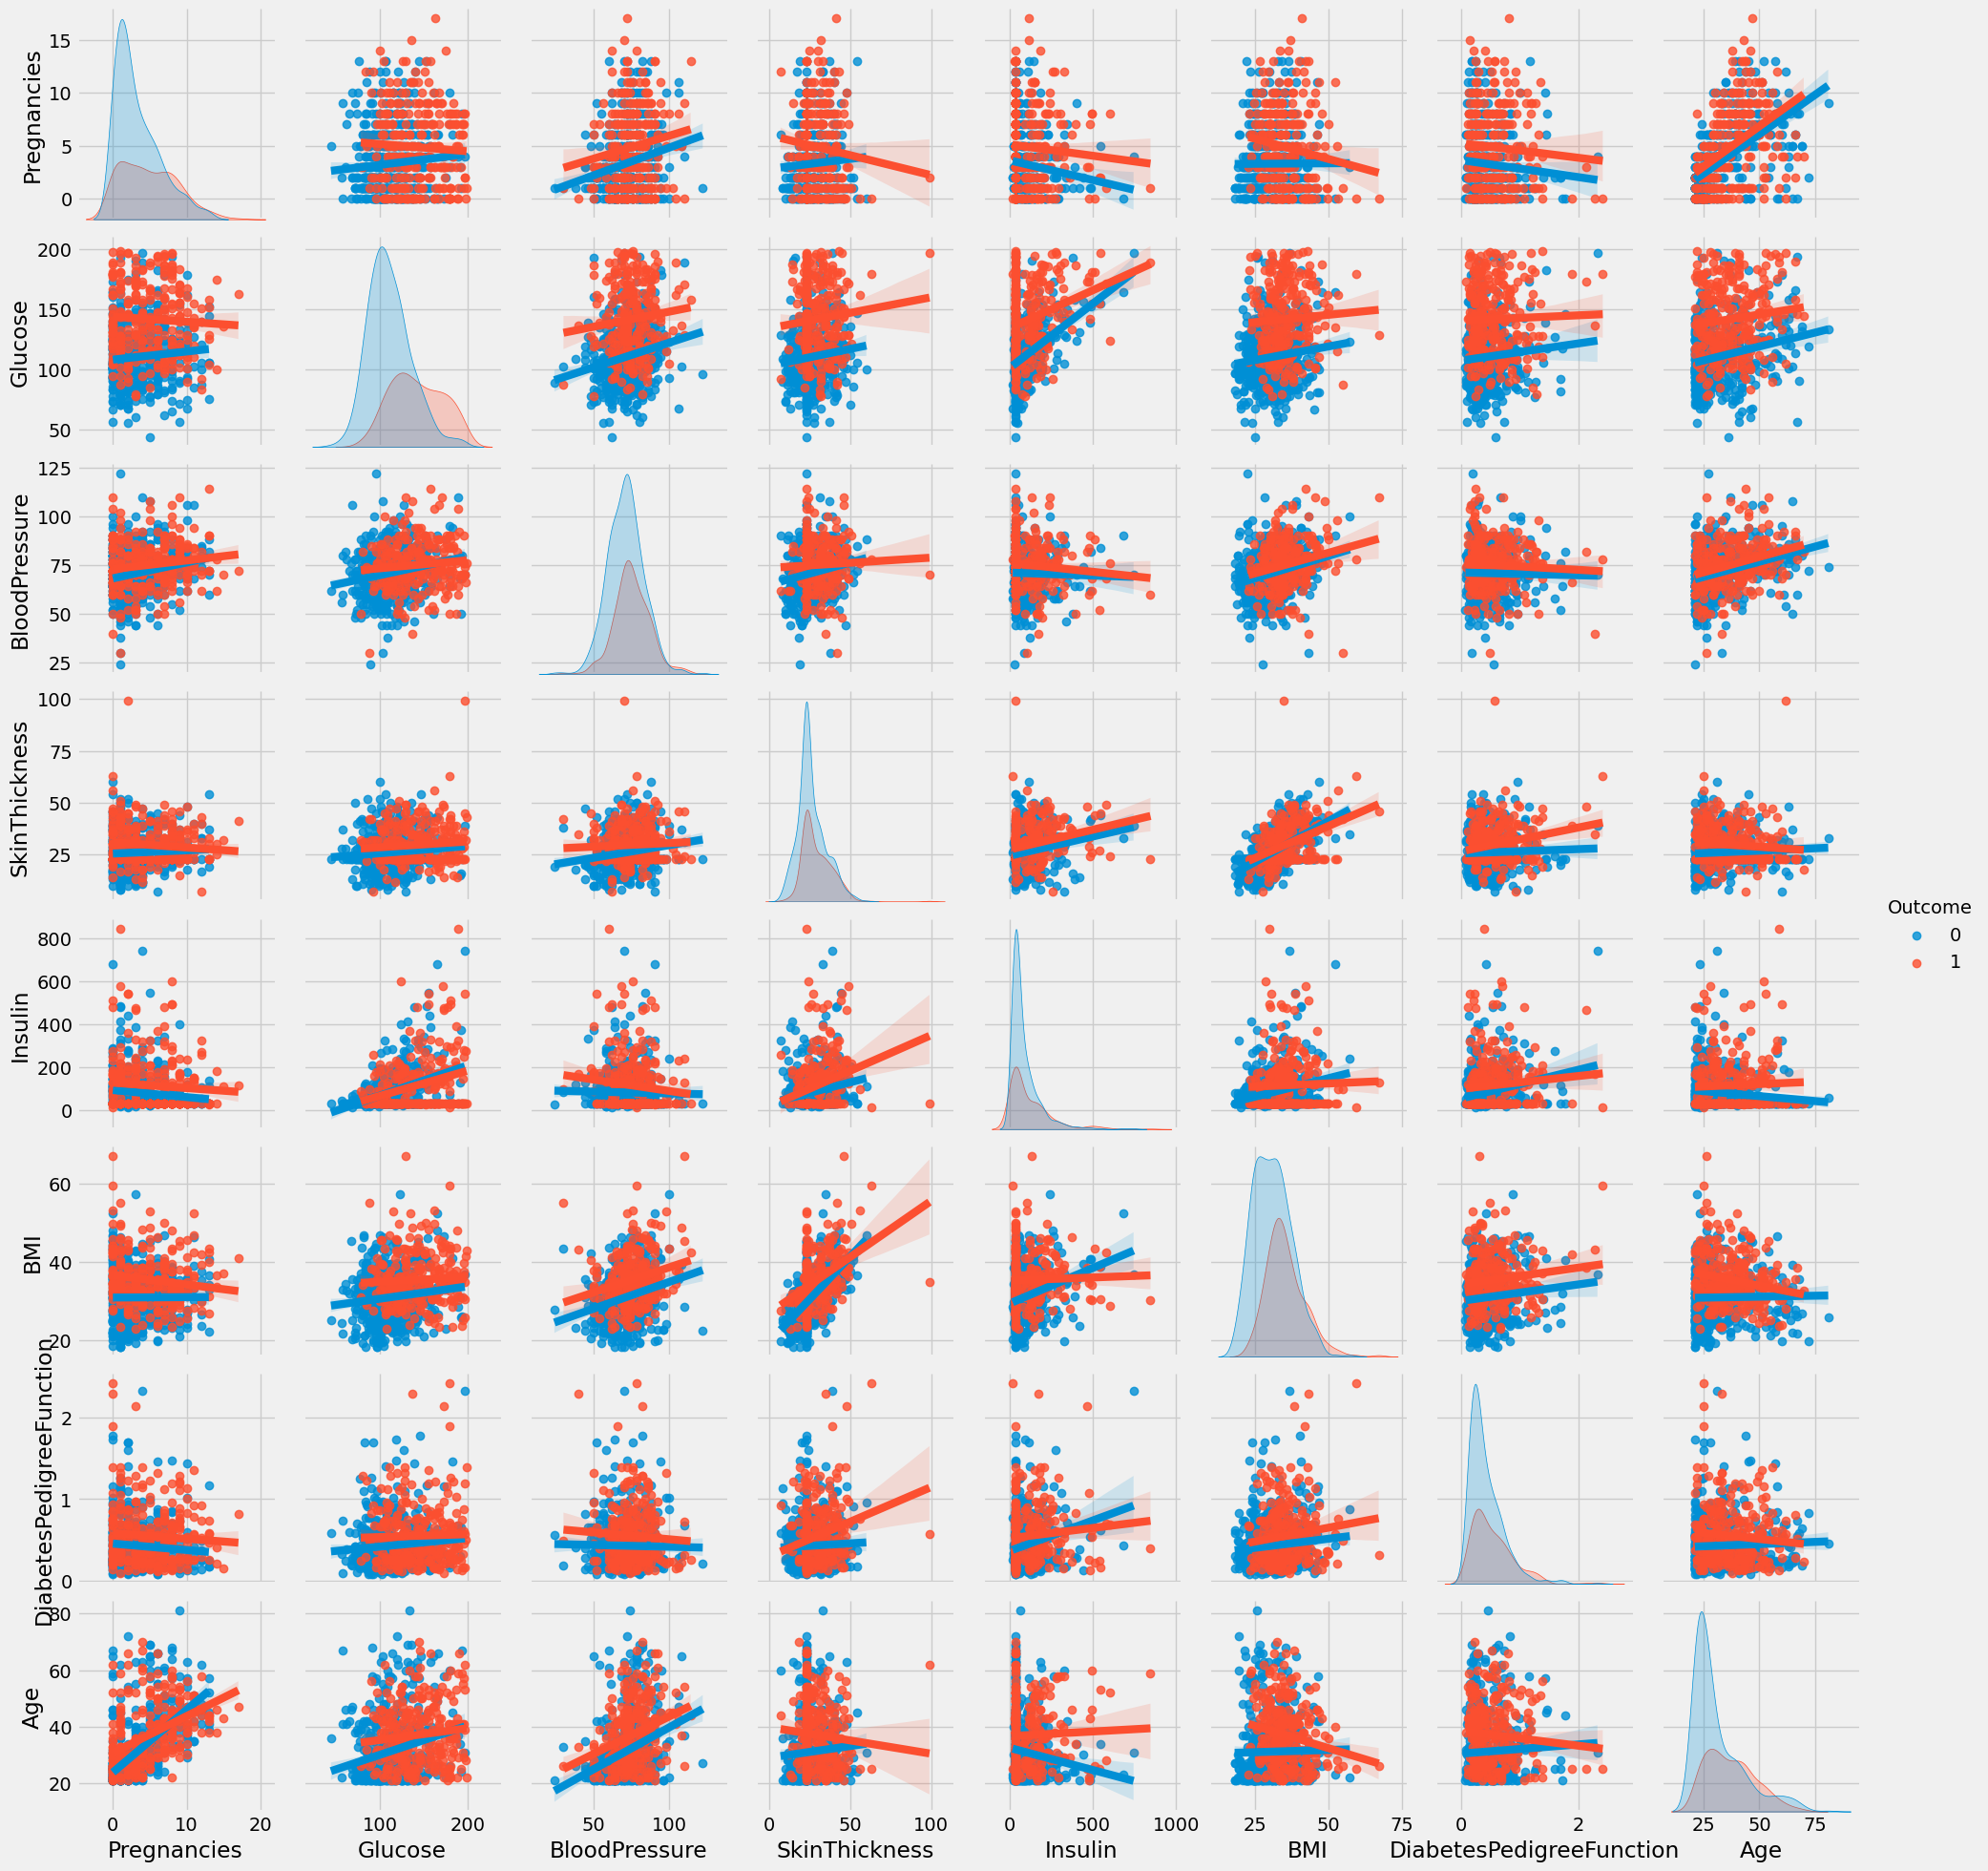

In [24]:
sns.pairplot(data=df, hue='Outcome', kind='reg')
plt.show()

##### Correlations and Heatmaps

In [25]:
df[df.columns[:]].corr()['Outcome']

Pregnancies                 0.221898
Glucose                     0.492782
BloodPressure               0.165723
SkinThickness               0.189065
Insulin                     0.148457
BMI                         0.312249
DiabetesPedigreeFunction    0.173844
Age                         0.238356
Outcome                     1.000000
Name: Outcome, dtype: float64

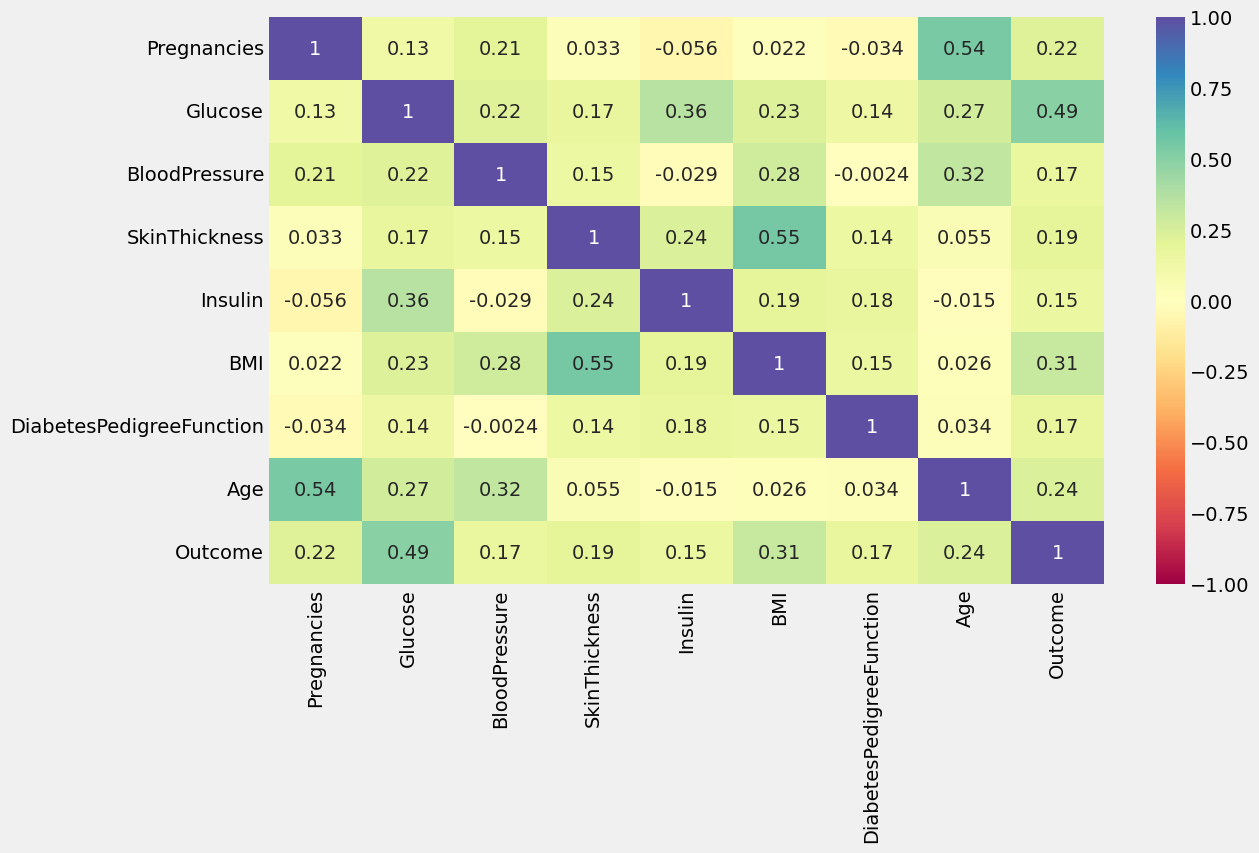

In [26]:
plt.figure(figsize=(12,7))
sns.heatmap(df.corr(), annot=True, cmap='Spectral', vmax=+1, vmin=-1)
plt.show()

**Observations**
Glucose and BMI seem to be strongest predictors of Diabetes

In [27]:
%%writefile eda.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import streamlit as st
st.set_option('deprecation.showPyplotGlobalUse', False)
st.title("The EDA Page")

def main():
    st.sidebar.subheader("Please choose the plot")
    data=pd.read_csv('data.csv')
    # drop the redundant column
    data=data.drop('Unnamed: 0', axis=1)
    # treat the nulls
    zerofiller=lambda x: x.replace(0, x.median())
    cols=data.columns[1:6]
    data[cols]=data[cols].apply(zerofiller, axis=0)
    #encode categoricals
    df=data.copy()
    d={'Yes':1, 'No':0}
    df['Outcome']=df['Outcome'].map(d)
    
    def histograms(data):
        st.subheader('Univariate Histogram')
        data.hist()
        plt.tight_layout()
        st.pyplot()
    def barchart(data, feature):
        st.subheader("Barchart of Categoricals")
        ax=sns.countplot(data=data, x=feature, color='green')
        for p in ax.patches:
            x=p.get_bbox().get_points()[:,0]
            y=p.get_bbox().get_points()[1,1]
            ax.annotate("{:.2g}%".format(100.*y/len(data)), (x.mean(),y), ha='center' , va='bottom')                                  
        st.pyplot()
        
    def heatmap(data):
        st.subheader("The Heatmap")
        plt.figure(figsize=(12,7))
        sns.heatmap(df.corr(), annot=True, cmap='Spectral', vmax=+1, vmin=-1)
        st.pyplot()
        
    plot=st.sidebar.selectbox('Choose Plot',('Histograms', 'Barchart', 'Heatmap'))
    if st.sidebar.button("PLOT"):
        if plot=='Histograms':
            histograms(df)
        if plot=='Barchart':
            barchart(data=df, feature='Outcome')
        if plot=='Heatmap':
            heatmap(data=df)
        
if __name__=='__main__':
    main()

Overwriting eda.py


### Preprocess the data for modelling 

In [28]:
# Create a function fro preprocessing
def preprocess(df, label):
    X = df.drop(label, axis = 1)
    y = df[label]
    from imblearn.over_sampling import SMOTE
    sm = SMOTE()
    X,y = sm.fit_resample(X,y)
    x_train, x_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state=69)
    return x_train, x_test, y_train, y_test

In [29]:
X_train, X_test, y_train, y_test = preprocess(df,'Outcome')

In [30]:
# Scale the Features
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [31]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(700, 8) (700,) (300, 8) (300,)


** The Data is now ready for modelling**

### Fit and Evaluate various Models

In [32]:
# Function for print metrics
def print_metrics(y_test,y_pred,model):
    print(f'Metrics for the model {model}')
    print('')
    print(f'Accuracy Score is {accuracy_score(y_test, y_pred)}')
    print(f'Recall Score is {recall_score(y_test, y_pred)}')
    print(f'Precision Score is {precision_score(y_test, y_pred)}')
    print(f'F1 Score is {f1_score(y_test, y_pred)}')
    print(f'ROC Score is {roc_auc_score(y_test, y_pred)}')
    print('Confusion Matrix')
    print(confusion_matrix(y_test,y_pred))
    print('Classification Report')
    print(classification_report(y_test,y_pred))

In [33]:
def plot_metrics(clf, x_test, y_test, model):
    print(f'Metric Plots for model {model}')
    plot_confusion_matrix(clf, x_test, y_test, labels = [0,1])
    print('')
    plot_roc_curve(clf,x_test,y_test)
    print('')
    plot_precision_recall_curve(clf, x_test, y_test)

In [34]:
# Create amnd fit a KNN model
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print_metrics(y_test, y_pred, 'KNN')

Metrics for the model KNN

Accuracy Score is 0.76
Recall Score is 0.8525641025641025
Precision Score is 0.7307692307692307
F1 Score is 0.7869822485207101
ROC Score is 0.7561431623931625
Confusion Matrix
[[ 95  49]
 [ 23 133]]
Classification Report
              precision    recall  f1-score   support

           0       0.81      0.66      0.73       144
           1       0.73      0.85      0.79       156

    accuracy                           0.76       300
   macro avg       0.77      0.76      0.76       300
weighted avg       0.77      0.76      0.76       300



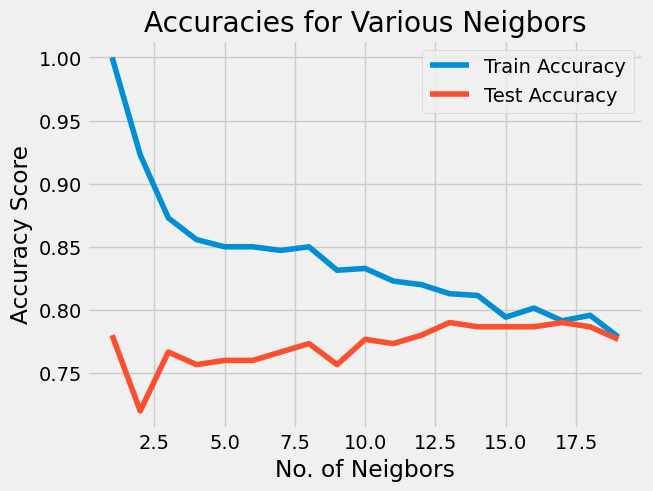

In [35]:
# Trying to optimize the KNN using a model complexity curve
neighbors = np.arange(1,20)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Enumerate along the neighbors
for i, k in enumerate(neighbors):
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    train_accuracy[i]=knn.score(X_train, y_train)
    test_accuracy[i]=knn.score(X_test, y_test)
#Plot the model complexity curve
plt.title('Accuracies for Various Neigbors')
plt.plot(neighbors, train_accuracy, label = 'Train Accuracy')
plt.plot(neighbors, test_accuracy, label = 'Test Accuracy')
plt.xlabel('No. of Neigbors')
plt.ylabel('Accuracy Score')
plt.legend()
plt.show()

In [36]:
# Create amnd fit a KNN model
knn = KNeighborsClassifier(n_neighbors = 13)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print_metrics(y_test, y_pred, 'KNN')

Metrics for the model KNN

Accuracy Score is 0.79
Recall Score is 0.8653846153846154
Precision Score is 0.7627118644067796
F1 Score is 0.8108108108108109
ROC Score is 0.7868589743589743
Confusion Matrix
[[102  42]
 [ 21 135]]
Classification Report
              precision    recall  f1-score   support

           0       0.83      0.71      0.76       144
           1       0.76      0.87      0.81       156

    accuracy                           0.79       300
   macro avg       0.80      0.79      0.79       300
weighted avg       0.79      0.79      0.79       300



In [37]:
# Lets select the best model based on the f1_score and optimize it
clfs = {'KNN' : KNeighborsClassifier(), 'NaiveBayes':GaussianNB(), 'Logregs':LogisticRegression(), 'Decision Tree':DecisionTreeClassifier(), 'Random Forest':RandomForestClassifier(), 'Ada Boost':AdaBoostClassifier(), 'Gradient Boosting': GradientBoostingClassifier(), 'XG Boost': XGBClassifier(), 'SVM': SVC()}
models_report = pd.DataFrame(columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])
for clf, clf_name in list(zip(clfs.values(), clfs.keys())):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(f'Fitting the Model - {clf_name}')
    t = {'Model':clf_name, 'Accuracy': accuracy_score(y_test, y_pred), 'Precision' : precision_score(y_test, y_pred), 'Recall' : recall_score(y_test, y_pred), 'F1 Score' : recall_score(y_test, y_pred)}
    models_report = models_report.append(t, ignore_index = True)
models_report = models_report.sort_values(by = 'F1 Score', ascending = False)
models_report

Fitting the Model - KNN
Fitting the Model - NaiveBayes
Fitting the Model - Logregs
Fitting the Model - Decision Tree
Fitting the Model - Random Forest
Fitting the Model - Ada Boost
Fitting the Model - Gradient Boosting
Fitting the Model - XG Boost
Fitting the Model - SVM


,Model,Accuracy,Precision,Recall,F1 Score
4,Random Forest,0.836667,0.809249,0.897436,0.897436
6,Gradient Boosting,0.813333,0.794118,0.865385,0.865385
0,KNN,0.760000,0.730769,0.852564,0.852564
7,XG Boost,0.813333,0.801205,0.852564,0.852564
8,SVM,0.776667,0.757225,0.839744,0.839744
3,Decision Tree,0.770000,0.780645,0.775641,0.775641
5,Ada Boost,0.763333,0.781457,0.756410,0.756410
2,Logregs,0.730000,0.755102,0.711538,0.711538
1,NaiveBayes,0.700000,0.742647,0.647436,0.647436


**Random Forest has performed the best so lets optimize this model**

In [57]:
rfc = RandomForestClassifier(random_state = 0)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
print_metrics(y_test,y_pred,rfc)

Metrics for the model RandomForestClassifier(random_state=0)

Accuracy Score is 0.84
Recall Score is 0.8846153846153846
Precision Score is 0.8214285714285714
F1 Score is 0.8518518518518519
ROC Score is 0.8381410256410255
Confusion Matrix
[[114  30]
 [ 18 138]]
Classification Report
              precision    recall  f1-score   support

           0       0.86      0.79      0.83       144
           1       0.82      0.88      0.85       156

    accuracy                           0.84       300
   macro avg       0.84      0.84      0.84       300
weighted avg       0.84      0.84      0.84       300



In [58]:
param_grid = {'n_estimators' : [100,150,200,250], 'min_samples_leaf' : range(1,10,1), 'min_samples_split' : range(2,20,2), 'max_depth' : [2,4,'auto'], 'max_features' : ['sqrt','log2'], 'criterion' : ['gini','entropy']}
n_folds = 5
cv = GridSearchCV(estimator = rfc,param_grid = param_grid, cv = n_folds, n_jobs = -1, verbose = 3, return_train_score = False)
cv.fit(X_train, y_train)

Fitting 5 folds for each of 3888 candidates, totalling 19440 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 'auto'],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': range(1, 10),
                         'min_samples_split': range(2, 20, 2),
                         'n_estimators': [100, 150, 200, 250]},
             verbose=3)

In [59]:
cv.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=4, max_features='log2',
                       min_samples_leaf=2, min_samples_split=10,
                       n_estimators=150, random_state=0)

In [60]:
rf_tuned = RandomForestClassifier(criterion = 'entropy', max_depth=2, max_features='sqrt', min_samples_leaf = 2, min_samples_split = 6, random_state = 0)
rf_tuned = rf_tuned.fit(X_train, y_train)
y_pred = rf_tuned.predict(X_test)
print_metrics(y_test,y_pred,'rf_tuned')

Metrics for the model rf_tuned

Accuracy Score is 0.7833333333333333
Recall Score is 0.8333333333333334
Precision Score is 0.7692307692307693
F1 Score is 0.8
ROC Score is 0.7812500000000001
Confusion Matrix
[[105  39]
 [ 26 130]]
Classification Report
              precision    recall  f1-score   support

           0       0.80      0.73      0.76       144
           1       0.77      0.83      0.80       156

    accuracy                           0.78       300
   macro avg       0.79      0.78      0.78       300
weighted avg       0.78      0.78      0.78       300



### Pickle and save the model as a Pipeline

Metrics for the model Pipeline

Accuracy Score is 0.78
Recall Score is 0.8333333333333334
Precision Score is 0.7647058823529411
F1 Score is 0.7975460122699386
ROC Score is 0.7777777777777779
Confusion Matrix
[[104  40]
 [ 26 130]]
Classification Report
              precision    recall  f1-score   support

           0       0.80      0.72      0.76       144
           1       0.76      0.83      0.80       156

    accuracy                           0.78       300
   macro avg       0.78      0.78      0.78       300
weighted avg       0.78      0.78      0.78       300

Metric Plots for model Pipeline




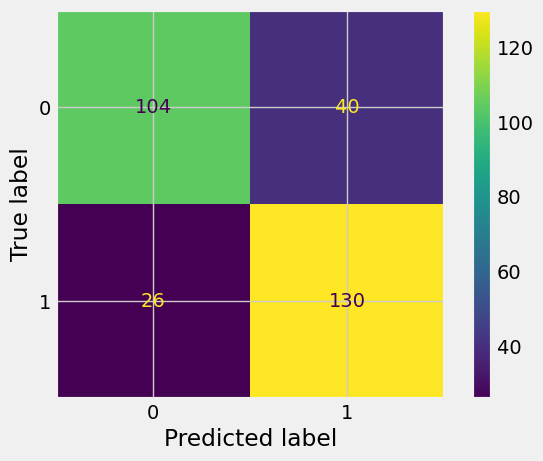

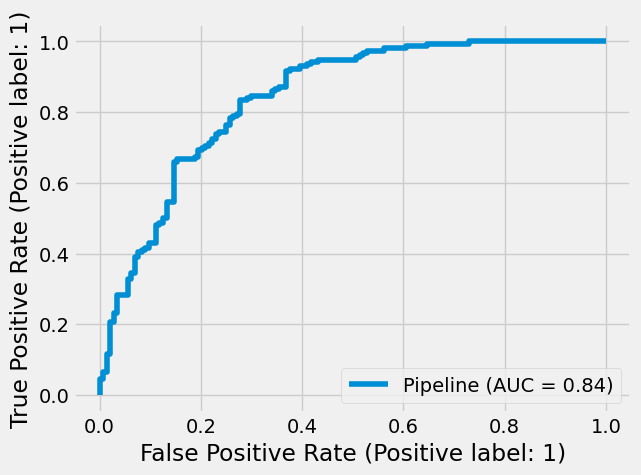

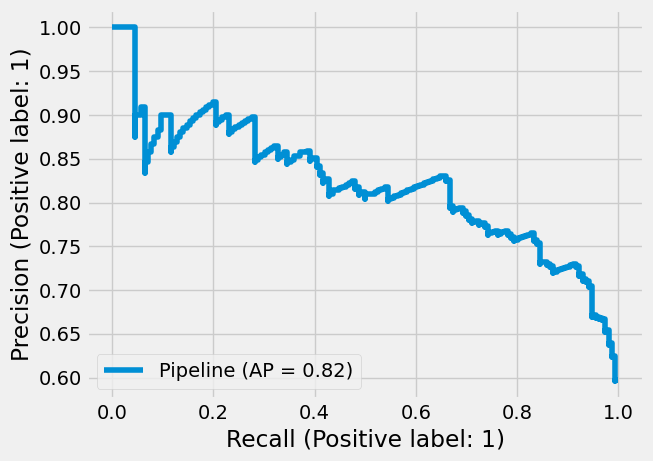

In [61]:
sc = StandardScaler()
rfc_tuned = rf_tuned
steps = [('scaler', sc), ('rfc_tuned', rfc_tuned)]
pipeline = Pipeline(steps)
x_train, x_test, y_train, y_test = preprocess(df, label = 'Outcome')
pipeline.fit(x_train, y_train)
y_pred = pipeline.predict(x_test)
print_metrics(y_test, y_pred, 'Pipeline')
plot_metrics(pipeline, x_test, y_test, 'Pipeline')

### Save the Pipeline as a Pickle File

In [62]:
# save the pipeline as pickle file
model = open('rfc.pickle', 'wb')
pickle.dump(pipeline, model)
model.close()

# Deploy the model as a streamlit file

In [63]:
%%writefile app.py
import streamlit as st
st.title('Medical Diagnostic Web App')
st.subheader('Is the patient Diabetic?')

import pandas as pd
import pickle
from sklearn.preprocessing import StandardScaler

# Step 1 : Load the pickled model
model = open('rfc.pickle', 'rb')
clf = pickle.load(model)
model.close()

# Step 2 : get input from the front end user
pregs = st.number_input('Pregnancies', 0, 17, 0) 
glucose = st.slider('Glucose', 40, 200, 40) 
bp = st.slider('BloodPressure', 20, 140, 20) 
skin = st.slider('SkinThickness', 7.0, 99.0, 7.0) 
insulin = st.slider('Insulin', 14, 850, 14) 
bmi = st.slider('BMI', 18, 70, 18) 
dpf = st.slider('DiabetesPedigreeFunction', 0.05, 2.5) 
age = st.slider('Age', 20, 90, 20)

# Step 3 : Collect the front end user input as model input data
data = {'Pregnancies' : pregs, 'Glucose' : glucose, 'BloodPressure' : bp, 'SkinThickness' : skin, 'Insulin' : insulin, 'BMI' : bmi, 'DiabetesPedigreeFunction' : dpf, 'Age' : age}
input_data = pd.DataFrame([data])
preds = clf.predict(input_data)[0]
if st.button('Predict'):
    if preds == 1:
        st.error('Diabetic')
    if preds == 0:
        st.success('Non Diabetic')

Overwriting app.py
